# DTW

In this notebook we implement a detection of exercice based with DTW (Dynamic time warping). We will see that it perform well but suffer from computing time.

In [46]:
from pathlib import Path
import sys

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

%matplotlib inline

# Data cleaning and merging

This function as to goal to merge the 2 captors data into 1 pandas array

In [2]:
# List the recordings in folder
# each recording folder must be named with the first word as the label, followed by an underscore: 
# e.g. `punch_xxx` and in this folder, the csv file corresponding. 
def get_data(base_dir, files):
    # read the data
    recordings = {}

    files = Path('.').joinpath(base_dir).glob(files)

    for f in sorted(files):

        data_info = str(f).split('/')[-1].split('_')
        label = data_info[0]
        placement = data_info[-2]
        val_type  = data_info[-1].split('.')[0]

        if(val_type == 'acc' and placement == 'arm'):
            this_gesture = pd.read_csv(f, header=0, names=['Phone timestamp','sensor timestamp [ns]','X [mg]','Y [mg]','Z [mg]'], index_col=0, sep=';', parse_dates=True)
            this_gesture = this_gesture.drop('sensor timestamp [ns]',axis=1)
            this_gesture = this_gesture.rename(columns={'X [mg]': 'X_arm', 'Y [mg]': 'Y_arm', 'Z [mg]': 'Z_arm'})
            this_gesture = this_gesture.resample('100ms').mean()

            if label in recordings.keys():             # if the label already exists in the dictionary
                recordings[label].append(this_gesture) # append the new gesture to the list
            else:
                recordings[label] = [this_gesture]     # otherwise, create a list with one element

        elif(val_type == 'acc' and placement == 'feet'):

            this_gesture = pd.read_csv(f, header=0, names=['Phone timestamp','sensor timestamp [ns]','X [mg]','Y [mg]','Z [mg]'], index_col=0, sep=';', parse_dates=True)
            this_gesture = this_gesture.rename(columns={'X [mg]': 'X_feet', 'Y [mg]': 'Y_feet', 'Z [mg]': 'Z_feet'})
            this_gesture = this_gesture.drop('sensor timestamp [ns]',axis=1)
            this_gesture = this_gesture.resample('100ms').mean()

            recordings[label][-1] = recordings[label][-1].join(this_gesture, how='inner', lsuffix='left', rsuffix='right')



    labels = recordings.keys()
    print(f'{len(labels)} labels found ({labels}).')

    return recordings


In [3]:
recordings = get_data('Data','**/*.txt')

4 labels found (dict_keys(['Dead', 'Ohp', 'Pullup', 'Squat'])).


# Plot of the data

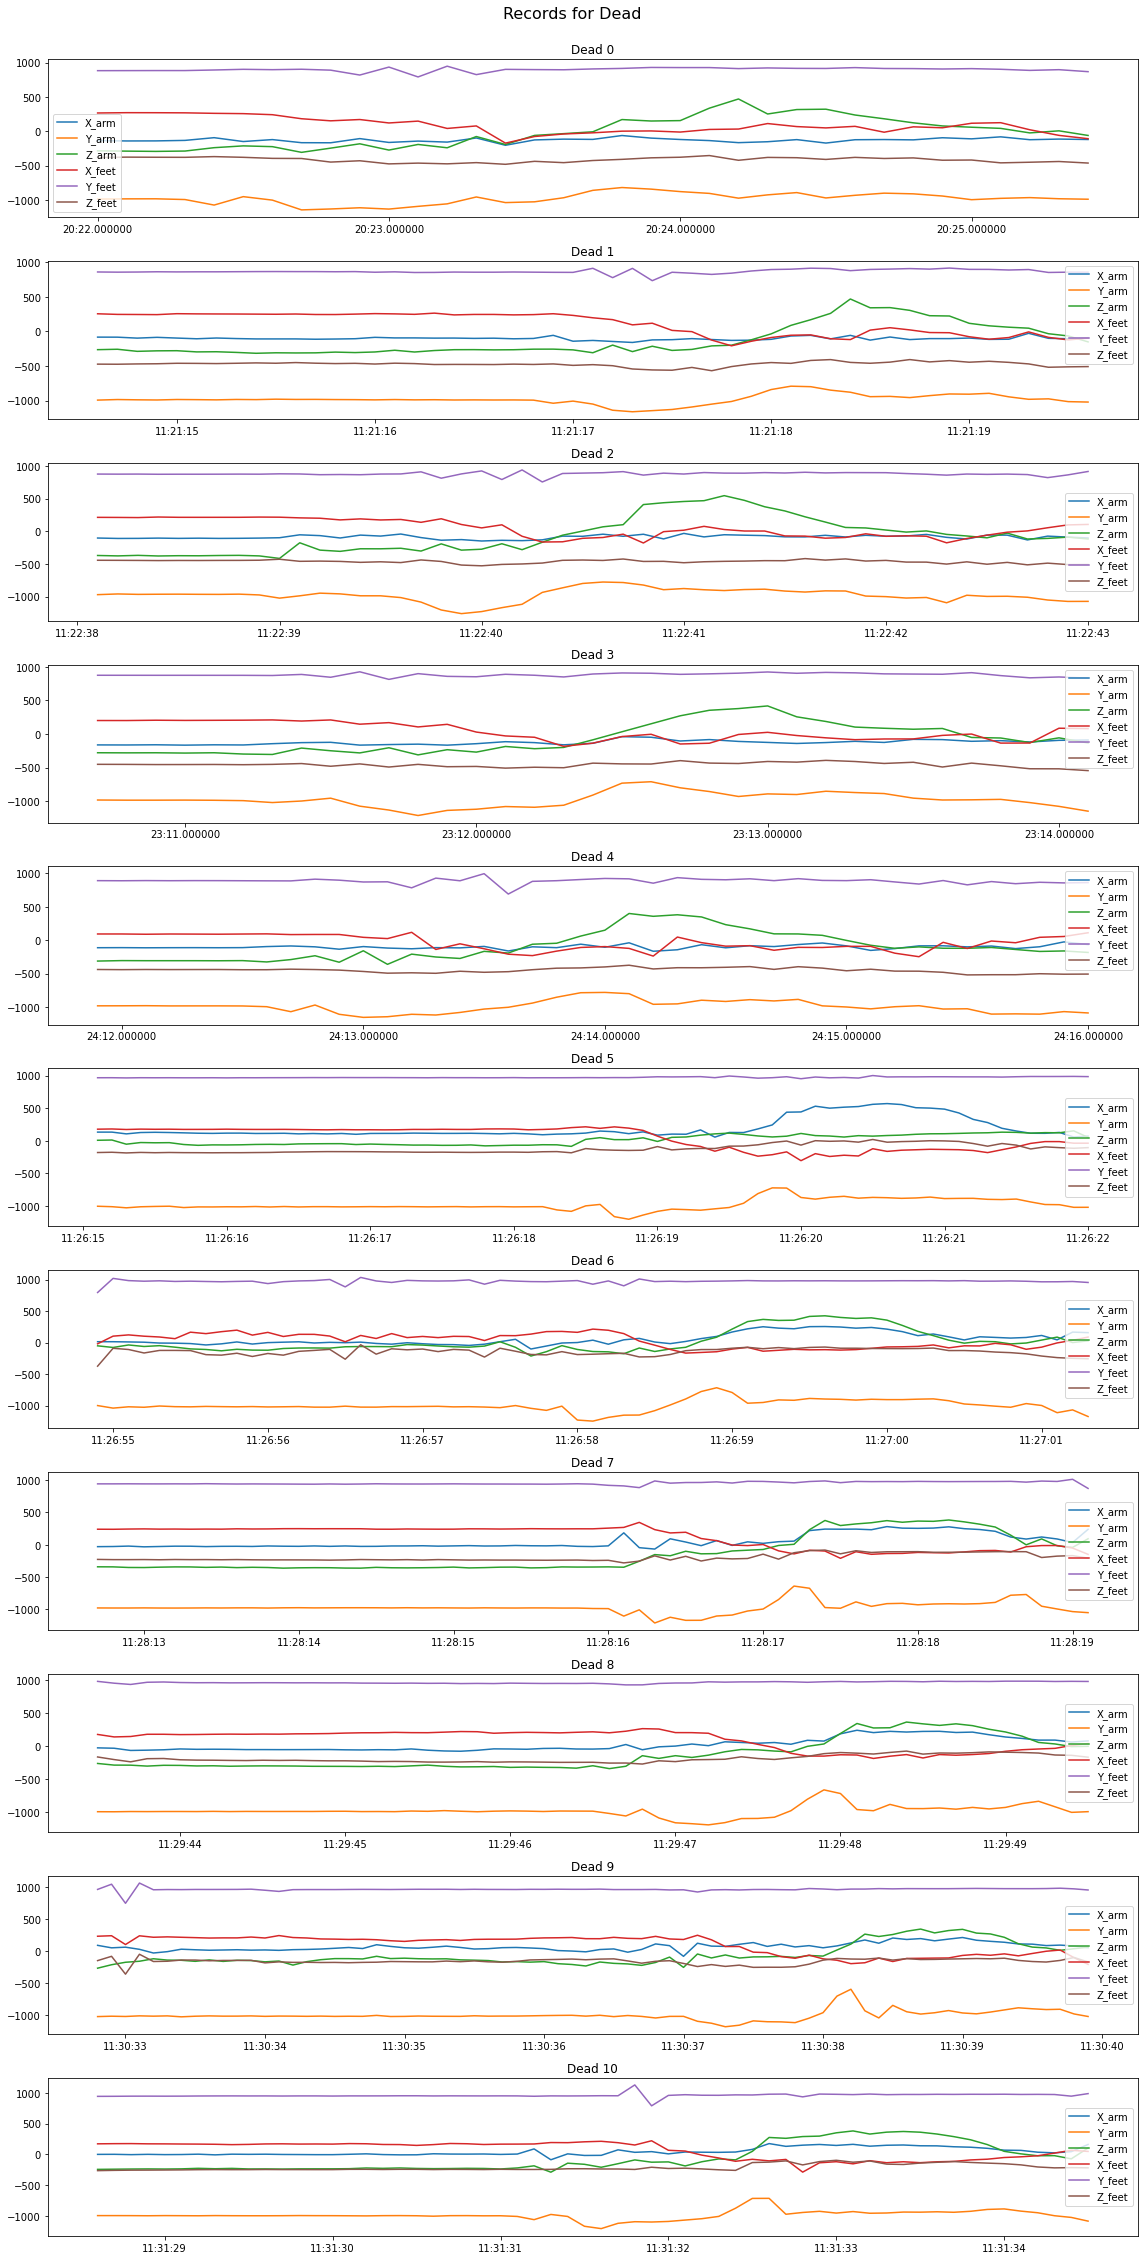

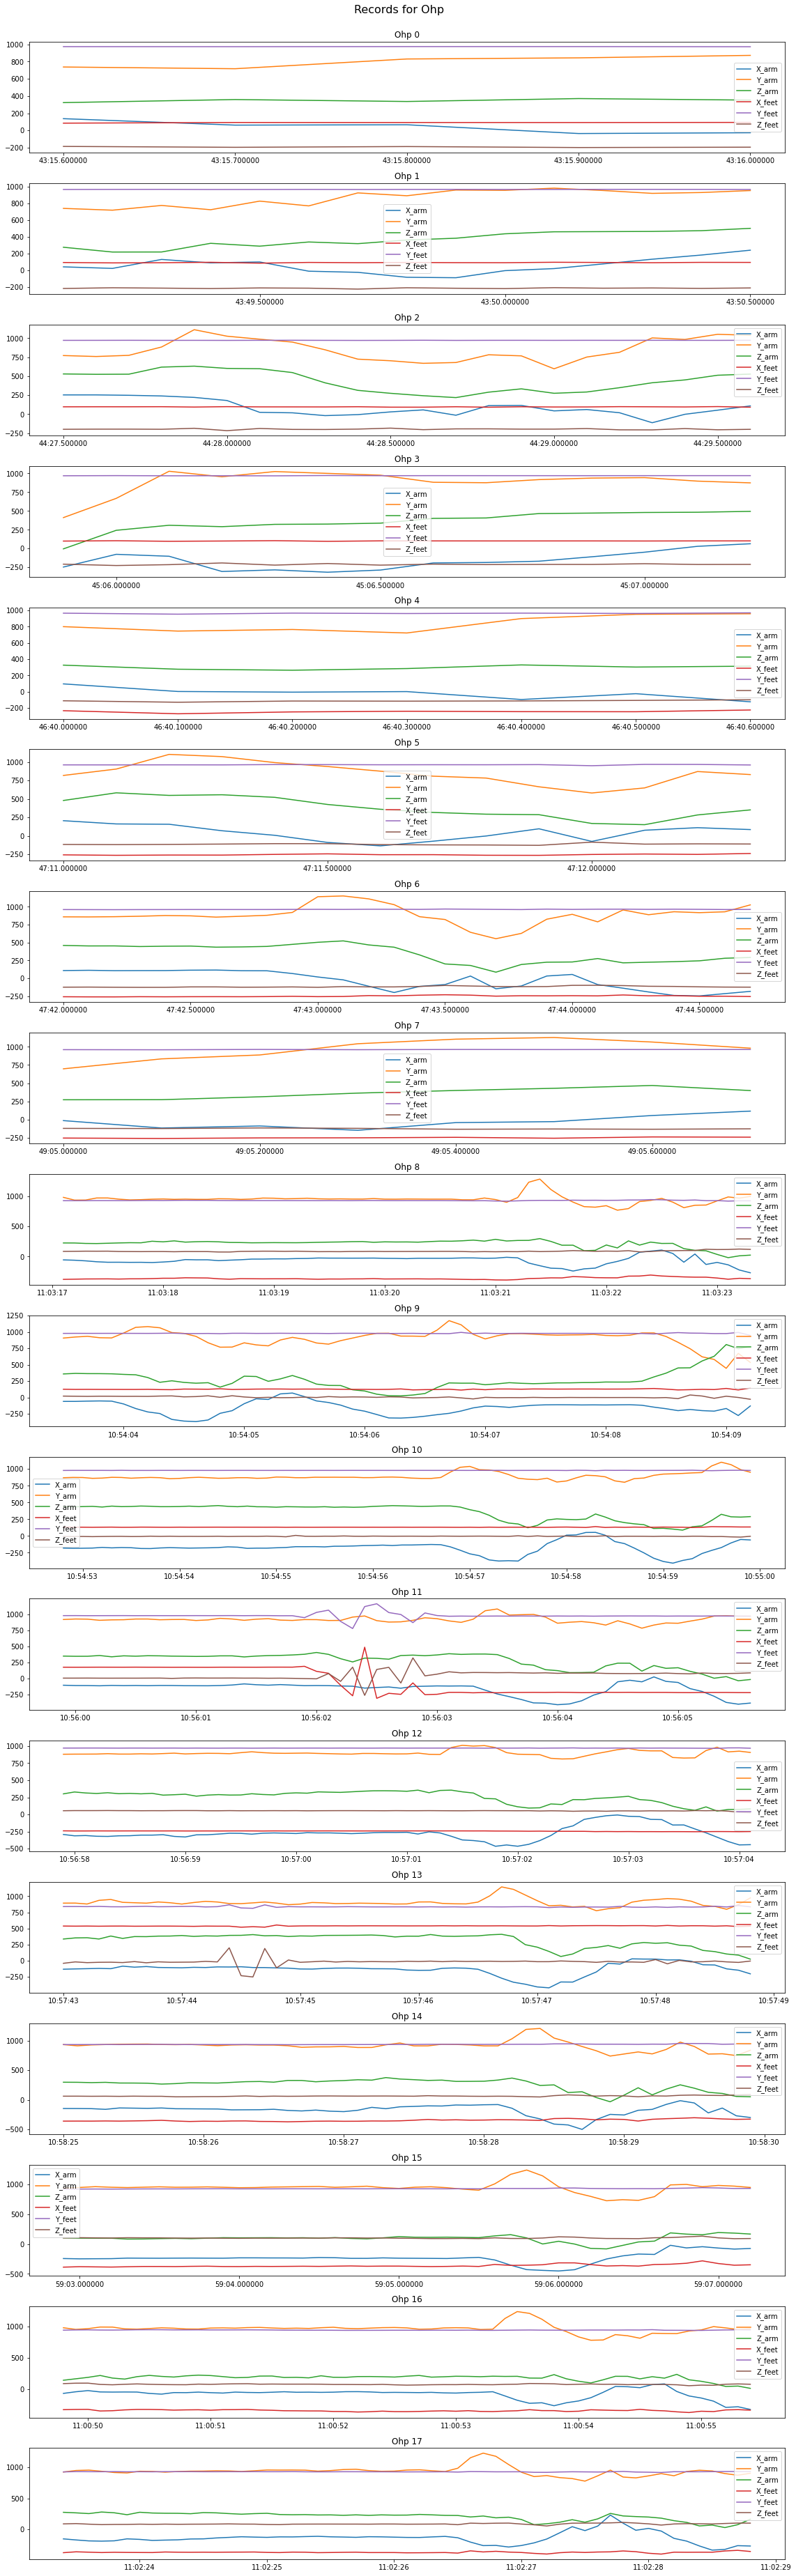

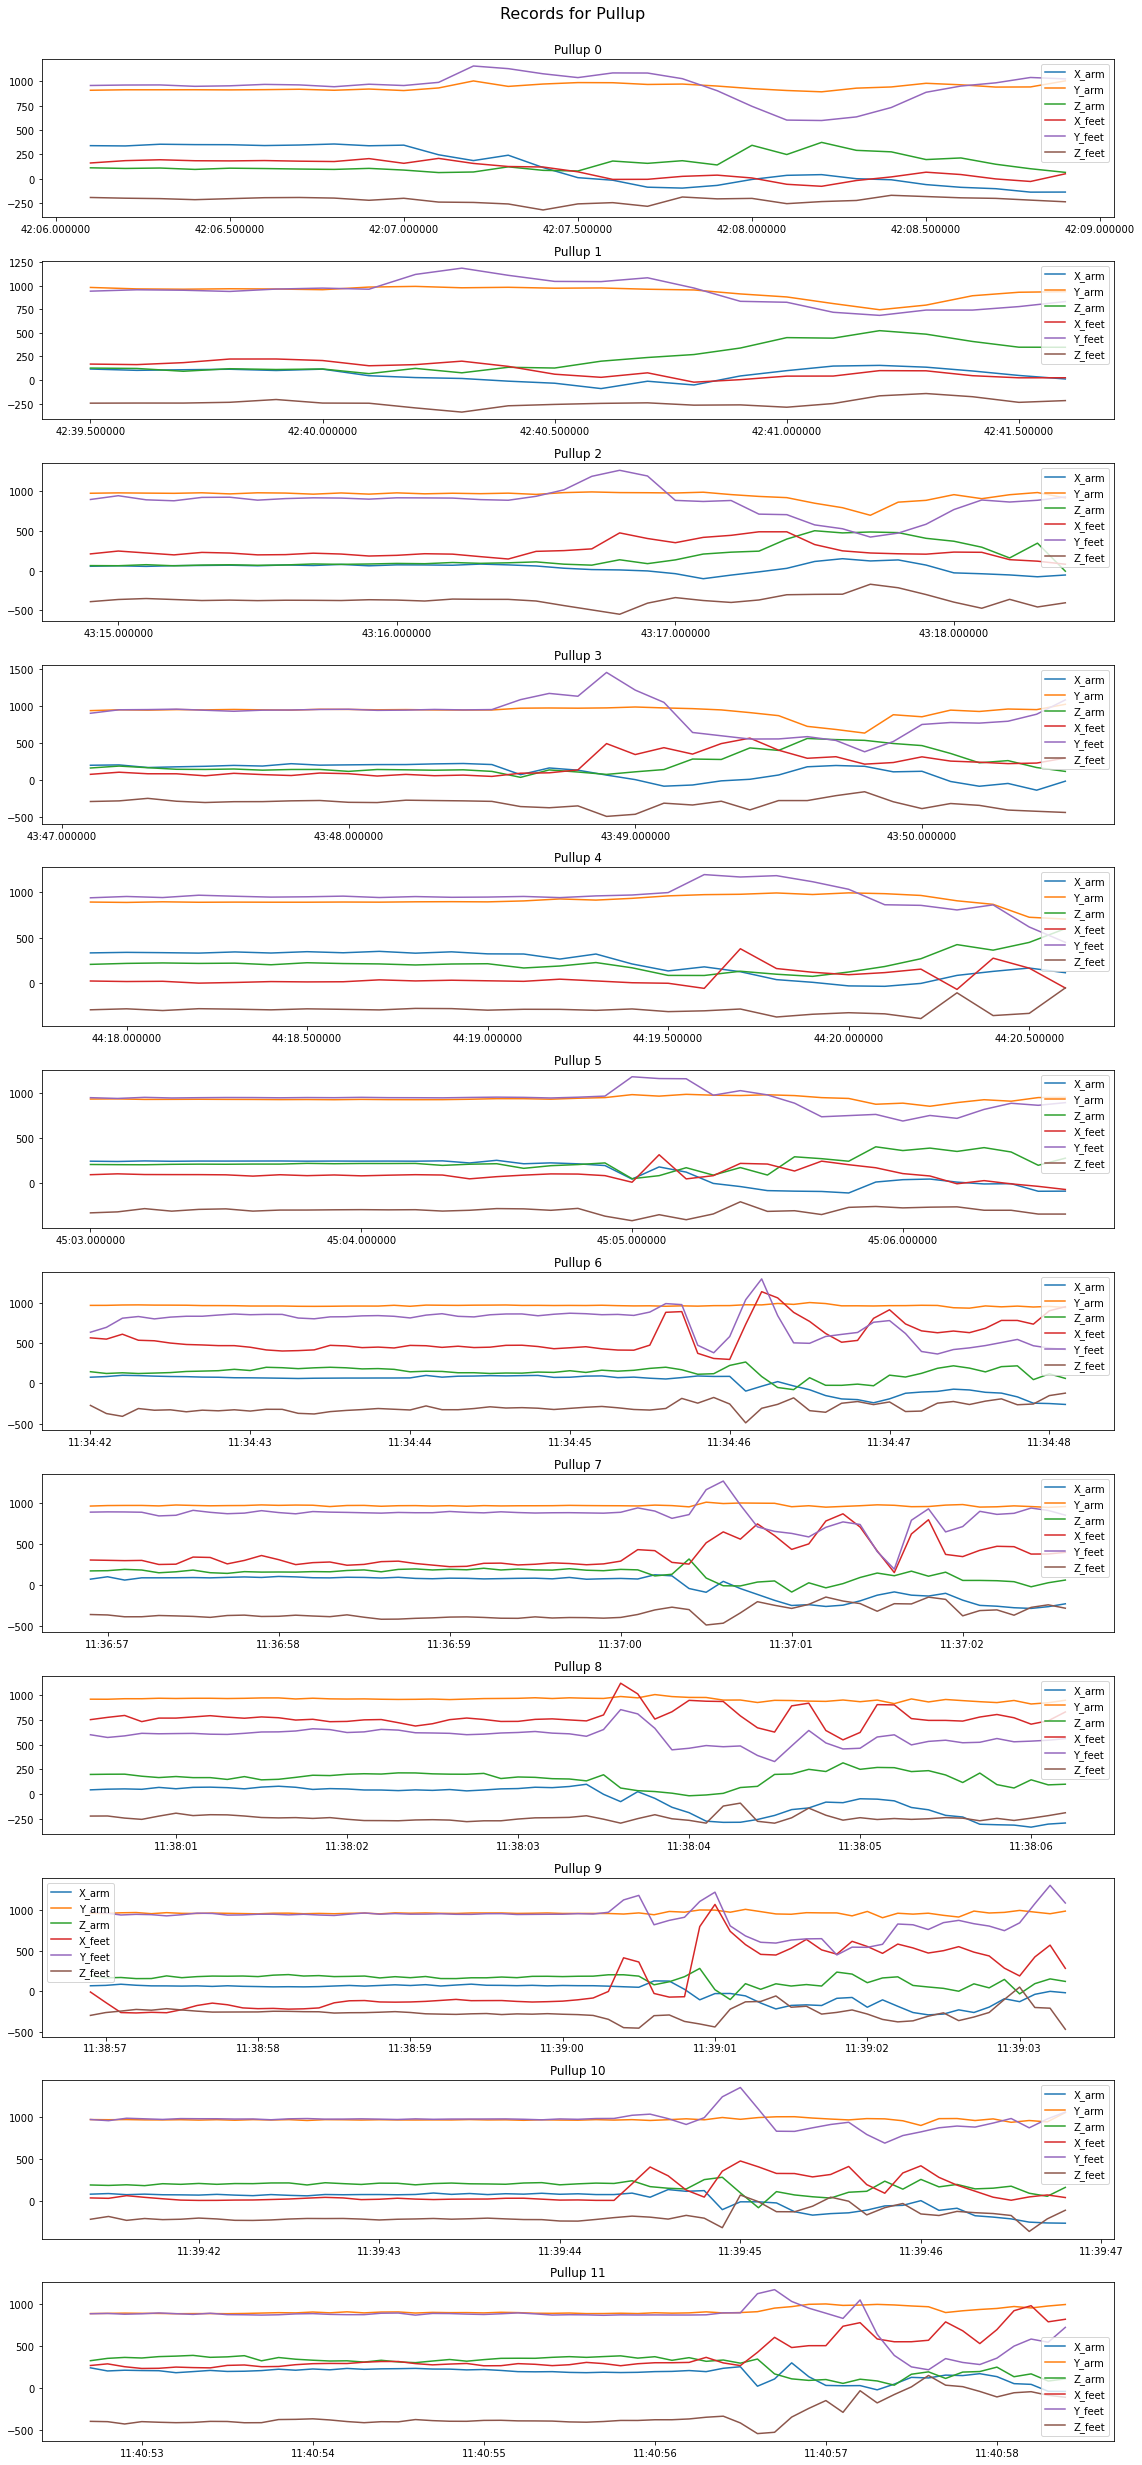

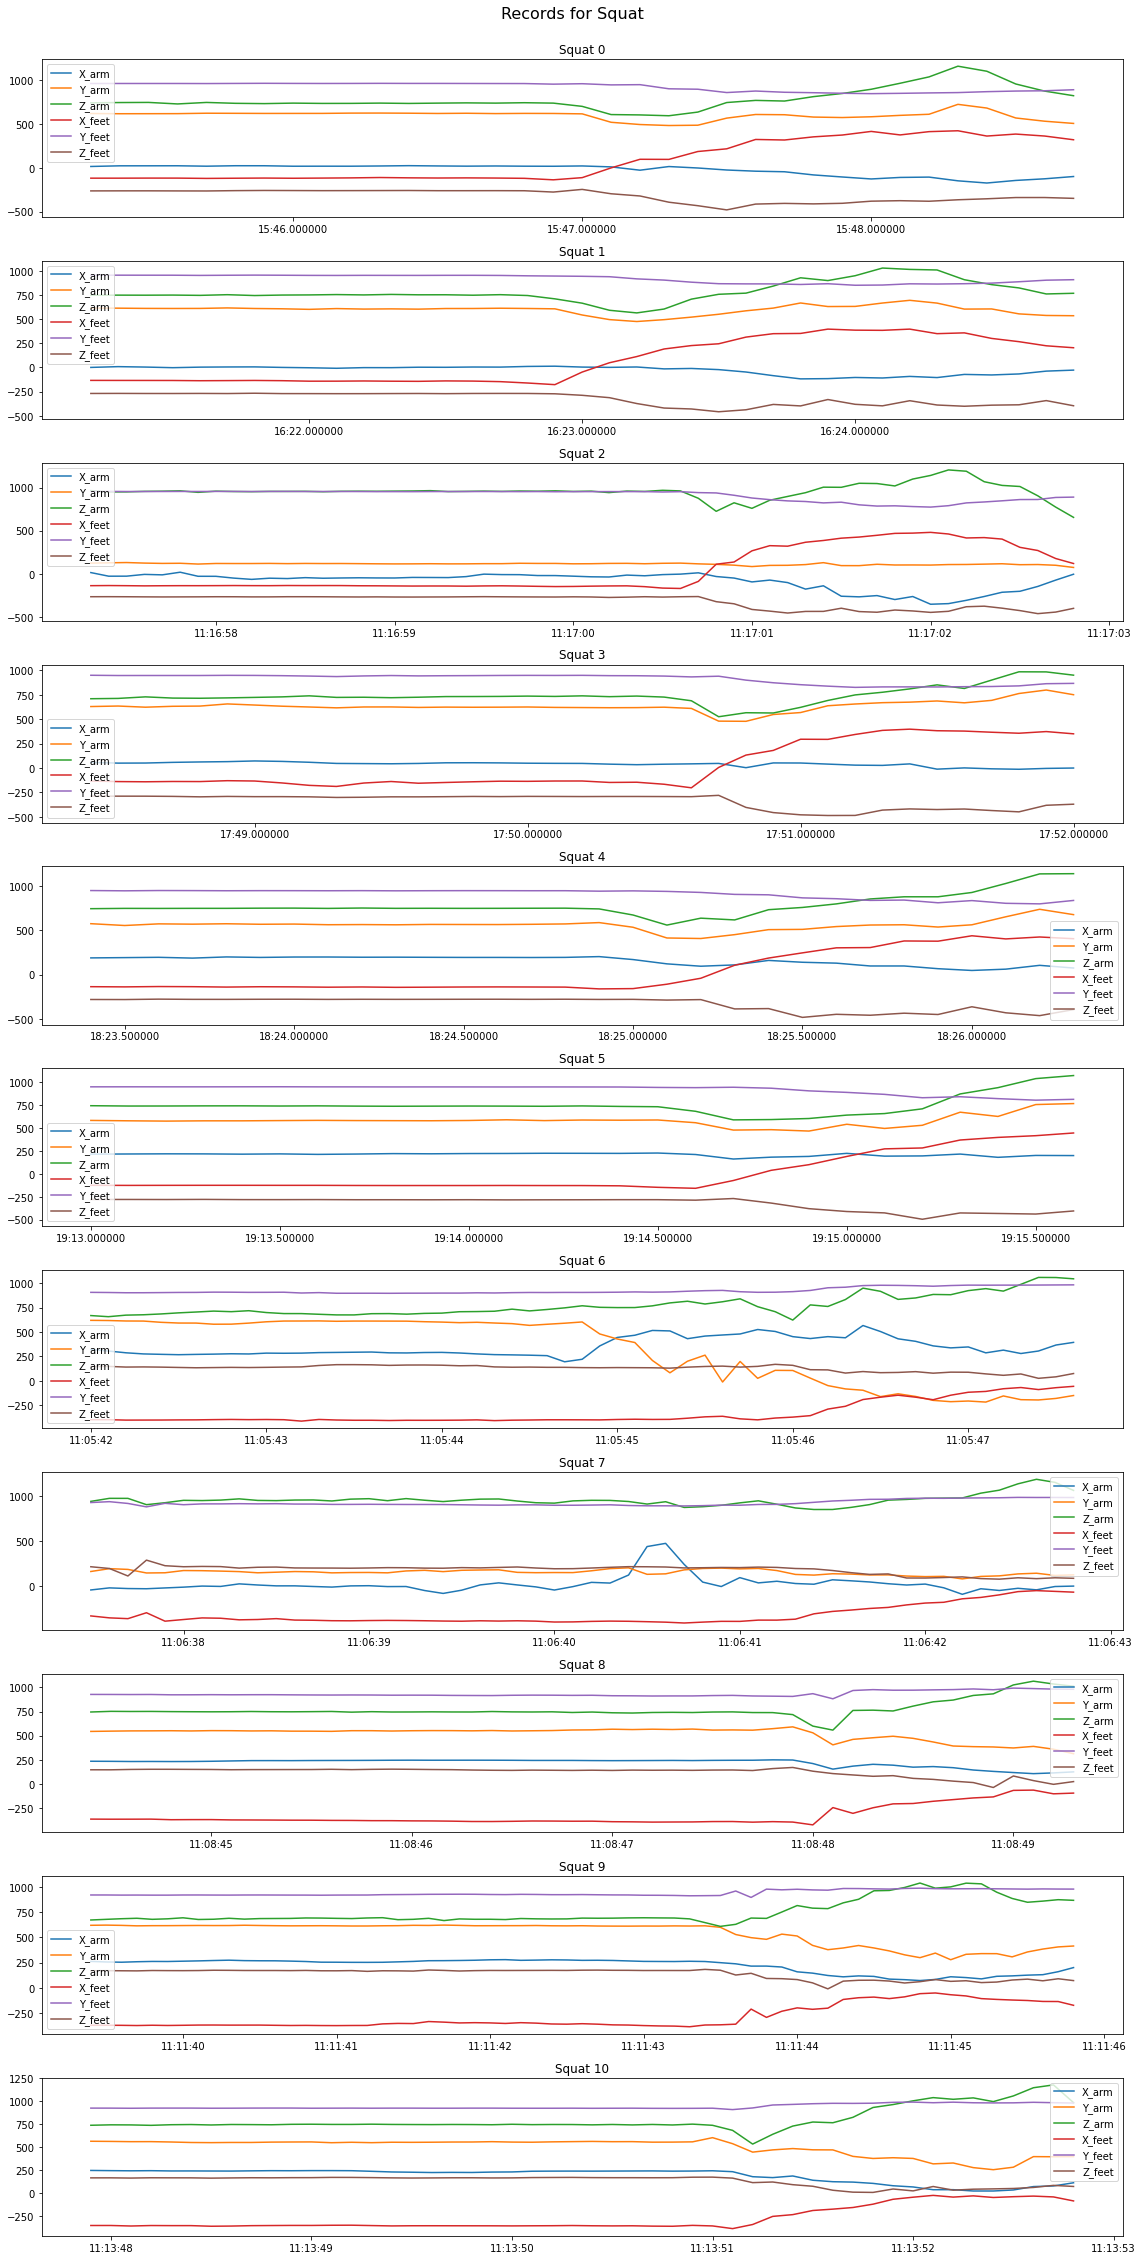

In [4]:
for label in recordings.keys():
    fig, axs = plt.subplots(len(recordings[label]), 1, figsize=(16, 3 * len(recordings[label])))
    
    for i, record in enumerate(recordings[label]):
        axs[i].plot(record[['X_arm','Y_arm','Z_arm','X_feet','Y_feet','Z_feet']])
        axs[i].set_title(f'{label.capitalize()} {i}', fontsize=12)
        axs[i].legend(['X_arm','Y_arm','Z_arm','X_feet','Y_feet','Z_feet'])
    fig.suptitle(f'Records for {label}', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])

below is the test serie we provide. it comprise 3 series of exercice (2 bench 1 Squat) and random movements.

1 labels found (dict_keys(['Test'])).


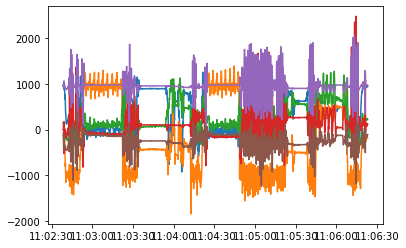

In [5]:
serie_record = get_data('Data_serie_test','**/*.txt')
serie_record = serie_record['Test'][0]
plt.plot(serie_record)

In [6]:
X = []
Y = []

max_nb_sample = 0
# pour chaque type de mouvement
for i, label in enumerate(recordings.keys()):
    # pour chaque enregistrement
    for record in recordings[label]:
        if max_nb_sample < record.shape[0]:
            max_nb_sample = record.shape[0]

In [7]:
X = {}

ignore = 0
# pour chaque type de mouvement
label_num = []
for i, label in enumerate(recordings.keys()):
    # pour chaque enregistrement
    diff = max_nb_sample - record.shape[0]
    temp = recordings[label][0]
    temp = np.pad(temp, ((diff,0),(0,0)), 'edge')
    temp = temp[ignore:-1]
    X[label] = temp

# movement sample

below is a movement sample from a Squat. it's only one repetition of the exercice.

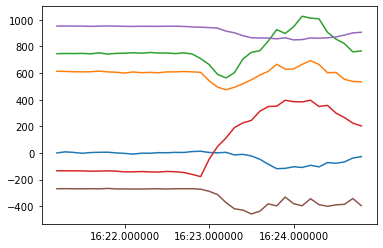

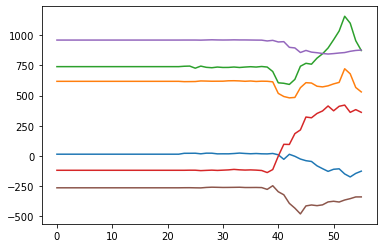

In [8]:
plt.plot(recordings['Squat'][1])
plt.show()
plt.plot(X['Squat'])

In [9]:
window = max_nb_sample
splits = []
while i + window < serie_record.shape[0]:
        
        # need to be done on the window and not the whole dataset
        split = serie_record[i:window+i]
        splits.append(split)
        i += 1

In [12]:
splits2 = np.array(splits)

# Isolation of the squat serie

below is the isolation of the squat serie in the test serie. We will try to see if the 2 patterns match like they should.

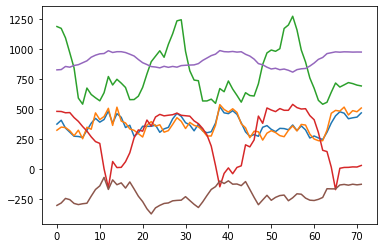

In [44]:
plt.plot(splits2[1940])

Ideed we can see that the pattern match quite nicely. So now we will try to perform a dtw on he entier serie by windowing the serie.

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

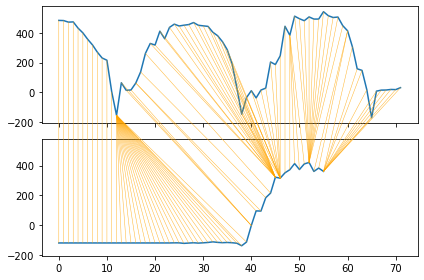

In [48]:
test = X['Squat']
path_1_2 = dtw.warping_path(splits2[1940][:,3], test[:,3])
dtwvis.plot_warping(splits2[1940][:,3], test[:,3], path_1_2)

In [231]:
preds = []

test = X['Squat']
print(test.shape)
for s in splits2:
    d = 0
    for feat in range(test.shape[1]):
        dist,path=dtw.warping_paths(s[:,feat], test[:,feat],4)
        d += dist
    d /= test.shape[1]
    preds.append(d)

(56, 6)


# Result

we see that we can not only find where the squat serie is but we can also find the bench serie by analogy. the only downnside is the computation time which is really high. DTW is really slow and even on a machine like a computer, it's slow.

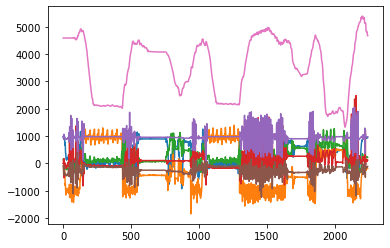

In [238]:
pred_int = np.pad(preds, (window+3,0), 'edge')

index = np.arange(0,serie_record.shape[0])

plt.plot(index, serie_record)
plt.plot(index, pred_int)